In [1]:
from typing import Sequence

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

#instantiating MLP with correct architecture
model = MLP([64, 64, 64, 64, 64, 4999])
batch = jnp.ones([1, 6])
variables = model.init(jax.random.key(0), batch)

In [2]:
%timeit model.apply(variables, batch)

12 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
#loading weights
kind_Cl = "TE"
capse_weights = jnp.load("weights_"+kind_Cl+"_lcdm.npy")
in_MinMax = jnp.load("inMinMax_lcdm.npy")
out_MinMax = jnp.load("outMinMaxCℓ"+kind_Cl+"_lcdm.npy")

In [4]:
#putting weights in the variables object
#now ugly, but I ensure you it works
layer_0_weights = capse_weights[0:64*6].reshape(6,64)
layer_0_bias = capse_weights[64*6:64*6+64]
layer_1_weights = capse_weights[64*6+64:64*6+64+64*64].reshape(64,64)
layer_1_bias = capse_weights[64*6+64+64*64:64*6+64+64*64+64]
layer_2_weights = capse_weights[64*6+64+64*64+64:64*6+64+64*64+64+64*64].reshape(64,64)
layer_2_bias = capse_weights[64*6+64+64*64+64+64*64:64*6+64+64*64+64+64*64+64]
layer_3_weights = capse_weights[64*6+64+64*64+64+64*64+64:64*6+64+64*64+64+64*64+64+64*64].reshape(64,64)
layer_3_bias = capse_weights[64*6+64+64*64+64+64*64+64+64*64:64*6+64+64*64+64+64*64+64+64*64+64]
layer_4_weights = capse_weights[64*6+64+64*64+64+64*64+64+64*64+64:64*6+64+64*64+64+64*64+64+64*64+64+64*64].reshape(64,64)
layer_4_bias = capse_weights[64*6+64+64*64+64+64*64+64+64*64+64+64*64:64*6+64+64*64+64+64*64+64+64*64+64+64*64+64]
layer_5_weights = capse_weights[64*6+64+64*64+64+64*64+64+64*64+64+64*64+64:64*6+64+64*64+64+64*64+64+64*64+64+64*64+64+64*4999].reshape(64,4999)
layer_5_bias = capse_weights[64*6+64+64*64+64+64*64+64+64*64+64+64*64+64+64*4999:64*6+64+64*64+64+64*64+64+64*64+64+64*64+64+64*4999+4999]

In [5]:
variables['params']['Dense_0']['kernel'] = layer_0_weights
variables['params']['Dense_0']['bias']   = layer_0_bias
variables['params']['Dense_1']['kernel'] = layer_1_weights
variables['params']['Dense_1']['bias']   = layer_1_bias
variables['params']['Dense_2']['kernel'] = layer_2_weights
variables['params']['Dense_2']['bias']   = layer_2_bias
variables['params']['Dense_3']['kernel'] = layer_3_weights
variables['params']['Dense_3']['bias']   = layer_3_bias
variables['params']['Dense_4']['kernel'] = layer_4_weights
variables['params']['Dense_4']['bias']   = layer_4_bias
variables['params']['Dense_5']['kernel'] = layer_5_weights
variables['params']['Dense_5']['bias']   = layer_5_bias

In [6]:
#defining the maximin and inv_maximin operations
@jax.jit
def maximin_input(input, in_MinMax):
    return (input - in_MinMax[:,0]) / (in_MinMax[:,1] - in_MinMax[:,0])

@jax.jit
def inv_maximin_output(output, out_MinMax):
    return output * (out_MinMax[:,1] - out_MinMax[:,0]) + out_MinMax[:,0]

In [7]:
%timeit maximin_input(np.array([3, 0.96, 67, 0.02, 0.12, 0.05]), in_MinMax)

29.3 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
x = np.random.rand(4999)
%timeit inv_maximin_output(x, out_MinMax)

33.8 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
norm_input = maximin_input(np.array([3, 0.96, 67, 0.02, 0.12, 0.05]), in_MinMax)

In [10]:
norm_model_output = model.apply(variables, norm_input)

In [11]:
model_output = inv_maximin_output(norm_model_output, out_MinMax)

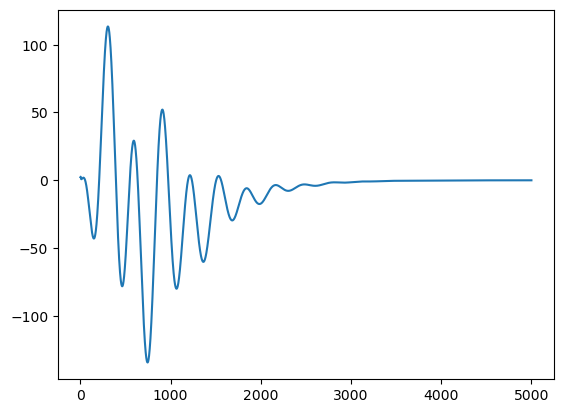

In [12]:
l = jnp.arange(2, 5000+1)
plt.plot(l, model_output)

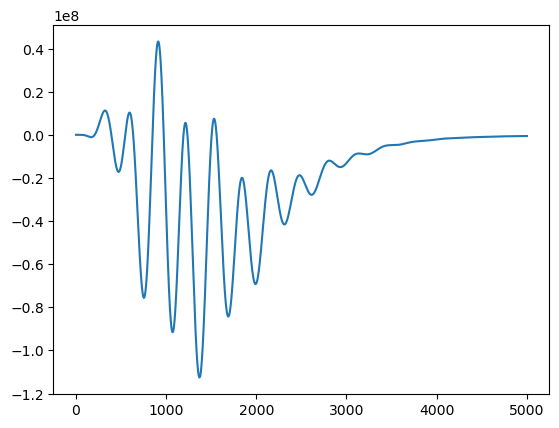

In [13]:
plt.plot(l, model_output*l*l)

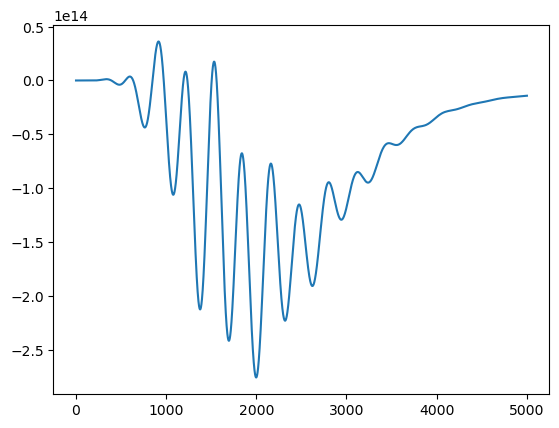

In [14]:
plt.plot(l, model_output*l*l*l*l)